In [2]:
import glob
import re

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
SEED = 8455

In [4]:
sns.set_style('darkgrid')

In [5]:
cols_to_skip = ['raw_text', 'language']

In [18]:
df_html_data = pd.concat([pd.read_csv(csv, lineterminator='\n', usecols=lambda x: x not in cols_to_skip)
               for csv in glob.glob('data/csv/*.csv')], ignore_index=True)
df_file_labels = pd.read_csv('data/html_targets.csv')
df = df_html_data.merge(df_file_labels, left_on='filename', right_on='file')
df = df.drop(['file', 'filename'], axis=1)

In [13]:
df.head()

,title,language,num_headers,num_paragraphs,num_tags,num_links,num_images,num_tables,num_lists,num_forms,...,has_google_analytics,has_google_tag_manager,has_google_remarketing,has_google_syndication,has_google_adsense,has_pubads,has_clicky,has_header_bidding,has_universal_pixel,sponsored
0,80-MPG Elio Three-Wheeled Car To Be Built At F...,en,21,22,882,193,65,0,20,6,...,True,True,False,False,False,False,False,False,False,0
1,"Bernie Sanders' Bold, New Plan May Have Just L...",NaN,5,17,572,151,76,0,4,1,...,False,False,False,False,False,False,False,False,True,0
2,"Wedding Dress Pictures, View Amazing Wedding G...",NaN,6,3,531,169,32,0,5,1,...,False,True,False,False,False,False,False,False,True,0
3,The Supreme Court hands down a major victory f...,NaN,145,6,2840,674,34,0,26,2,...,False,False,False,False,False,False,False,False,True,0
4,"Milano, il concerto dei Selton al Magnolia lo...",NaN,16,19,433,87,6,0,17,2,...,True,False,False,False,False,False,False,False,False,0


In [11]:
df.describe()

,num_headers,num_paragraphs,num_tags,num_links,num_images,num_tables,num_lists,num_forms,num_inputs,num_buttons,...,num_embeds,num_lines,num_words,num_italic_words,num_bold_words,num_characters,num_unique_words,num_unique_characters,num_digits,sponsored
count,337024.000000,337024.000000,337024.000000,337024.00000,337024.000000,337024.000000,337024.000000,337024.000000,337024.000000,337024.000000,...,337024.000000,337024.000000,3.370240e+05,337024.000000,337024.000000,3.370240e+05,337024.000000,337024.000000,337024.000000,337024.000000
mean,15.117422,29.244612,697.546198,144.11325,29.466815,1.345064,14.948155,2.277393,10.181800,1.672611,...,0.034030,1649.578327,4.344077e+03,7.302210,9.020832,2.984456e+04,570.453205,70.436984,388.203116,0.096963
std,26.249504,108.921037,1175.236909,325.99326,96.623238,13.146913,32.369360,7.288580,23.076891,9.672854,...,0.412587,2972.589774,2.417431e+04,37.006535,46.802491,1.226782e+05,722.457100,15.852156,2773.216815,0.295908
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,290.000000,48.00000,5.000000,0.000000,3.000000,1.000000,1.000000,0.000000,...,0.000000,686.000000,4.010000e+02,0.000000,0.000000,5.501000e+03,205.000000,68.000000,30.000000,0.000000
50%,9.000000,15.000000,528.000000,100.00000,17.000000,0.000000,9.000000,2.000000,5.000000,0.000000,...,0.000000,1185.000000,8.750000e+02,0.000000,1.000000,1.049200e+04,431.000000,74.000000,79.000000,0.000000
75%,18.000000,31.000000,834.000000,171.00000,35.000000,1.000000,18.000000,3.000000,12.000000,1.000000,...,0.000000,1899.250000,1.617000e+03,4.000000,7.000000,1.881100e+04,707.000000,79.000000,211.000000,0.000000
max,2924.000000,36328.000000,296536.000000,113886.00000,37065.000000,4551.000000,2721.000000,494.000000,2030.000000,1957.000000,...,74.000000,667203.000000,3.680651e+06,10621.000000,9934.000000,1.660190e+07,100023.000000,256.000000,822549.000000,1.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337024 entries, 0 to 337023
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   title                   324078 non-null  object
 1   language                209170 non-null  object
 2   num_headers             337024 non-null  int64 
 3   num_paragraphs          337024 non-null  int64 
 4   num_tags                337024 non-null  int64 
 5   num_links               337024 non-null  int64 
 6   num_images              337024 non-null  int64 
 7   num_tables              337024 non-null  int64 
 8   num_lists               337024 non-null  int64 
 9   num_forms               337024 non-null  int64 
 10  num_inputs              337024 non-null  int64 
 11  num_buttons             337024 non-null  int64 
 12  num_scripts             337024 non-null  int64 
 13  num_styles              337024 non-null  int64 
 14  num_iframes             337024 non-n

#### We are dealing with an imbalanced dataset with a ~10/90 split

<AxesSubplot:xlabel='sponsored', ylabel='count'>

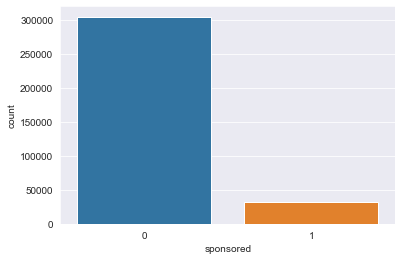

In [11]:
sns.countplot(data=df_file_labels, x='sponsored')

In [7]:
# import stop words
stop_words = set(stopwords.words('english') + \
                 stopwords.words('french') + \
                 stopwords.words('german') + \
                 stopwords.words('spanish'))

In [8]:
# split into train and test
X = df.drop(['sponsored'], axis=1)
y = df['sponsored']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

#### First model - Random Forest with random parameters

In [10]:
clf_rf = RandomForestClassifier(
    n_estimators=1000, max_depth=None, min_samples_split=2, 
    class_weight='balanced',
    random_state=SEED)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=8455)

In [11]:
y_pred_rf = clf_rf.predict(X_test)

In [23]:
# confidence in the Y | N?
clf_rf.predict_proba(X_test.iloc[:1])

array([[0.724, 0.276]])

In [13]:
confusion_matrix(y_test, y_pred_rf)

array([[60646,   300],
       [ 3684,  2775]])

In [14]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     60946
           1       0.90      0.43      0.58      6459

    accuracy                           0.94     67405
   macro avg       0.92      0.71      0.78     67405
weighted avg       0.94      0.94      0.93     67405



## Modelling sandbox

In [9]:
lemmer = WordNetLemmatizer()
text_transformer = TfidfVectorizer()

In [10]:
text_features = ['title']
transform_features = ['language']
numeric_features = [col for col in X.columns if 'num_' in col]
bool_features = [col for col in X.columns if 'has_' in col]

In [11]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, columns, stop_words=stopwords.words('english'), lemmer=WordNetLemmatizer()):
        self.columns = columns
        self.stop_words = stop_words
        self.lemmer = lemmer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        _X = X.copy()
        for column in self.columns:
            print(f"Processing {column} column")
            _X[column] = _X[column].fillna('')
            _X[column] = _X[column].map(lambda x: x.lower())
            _X[column] = _X[column].map(lambda x: re.sub(r'[^\w\s]', '', x))
            _X[column] = _X[column].map(lambda x: re.sub(r'\d+', '', x))
            _X[column] = _X[column].map(lambda x: [lemmer.lemmatize(
                word) for word in x.split() if word not in self.stop_words])
            _X[column] = _X[column].map(lambda x: ' '.join(x))
            print(f"{column} cleaned")
        return _X


### Random Forest

In [ ]:
clf = RandomForestClassifier(
    random_state=42
)

preprocessor = Pipeline(steps=[
    ('text_preprocessor', TextPreprocessor(columns=text_features,
                                           stop_words=stop_words,
                                           lemmer=lemmer))
])

ct = ColumnTransformer(
    [
        ('tfidf', text_transformer, text_features)
    ])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ct', ct),
    ('clf', clf)
])

param_grid = {
    'ct__tfidf__ngram_range': [[1, 1], [1, 2]],
    'ct__tfidf__max_features': [100, 500, 1000],
    'clf__n_estimators': [50, 100, 150],
    'clf__class_weight': ['balanced'],
    'clf__max_samples': [0.2, 0.5, 0.7],
    'clf__min_samples_split': [2, 5, 7]
}

pipe = GridSearchCV(
    pipe,
    param_grid,
    cv=10,
    n_jobs=-1,
    scoring='f1_macro',
    return_train_score=True,
    verbose=2
)

pipe = pipe.fit(X_train, y_train)
print(pipe.best_score_)
print(pipe.best_params_)


Fitting 10 folds for each of 3 candidates, totalling 30 fits


### XGBoost

In [ ]:
clf = RandomForestClassifier(
    random_state=42
)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

t = Pipeline(steps = [
   ('extractor', TextPreprocessor(columns=text_features, 
                               stop_words=stop_words,
                              lemmer=lemmer))
])

preprocessor = Pipeline(steps=[
    ('ct', ColumnTransformer(
            [
            ('num', numeric_transformer, numeric_features),
 #          ('log', FunctionTransformer(np.log1p, validate=False), numeric_features)
        ],
    remainder = 'passthrough',
    sparse_threshold=0)),
    ('variance_threshold', VarianceThreshold(threshold=0.1)),
    ('best_feature_selector', SelectKBest(k=10))
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('clf', clf)
])

param_grid = {
    'preprocessor__ct__num__scaler__with_mean': [True, False],
    'preprocessor__ct__num__scaler__with_std': [True, False],
    'preprocessor__variance_threshold__threshold': [0, 0.1, 0.2],
    'preprocessor__best_feature_selector__k': [10, 15, 20],
    'clf__n_estimators': [50, 100, 150],
    'clf__max_features': [0.2, 0.4, 0.6, 1],
    'clf__max_depth': [None, 3, 5, 7],
    'clf__criterion': ['gini', 'entropy'], 
    'clf__class_weight':[None, 'balanced'],
}

pipe = GridSearchCV(
    pipe, 
    param_grid, 
    cv=10, 
    n_jobs=-1, 
    scoring='f1_macro', 
    return_train_score=True, 
    verbose=2
)

pipe = pipe.fit(X_train, y_train)
print(pipe.best_score_)
print(pipe.best_params_)